### Notebook to Research diabetes onset 


#### Matched Controls Diabetes Onset Curve Construction Details

   1. <div style="background:Aliceblue"> <strong>Get all the canary patients who have their CC_DIABETES flag equals 0
    on their registration date.</strong>
   </div>
   
       - Pick a matching algorithm
       
   2. <div style="background:Aliceblue"><strong> Create the macthed population</strong> </div>
   
       - For each canary patient let their registration month be $i$
       - Find N(for example 50)  control patients to match this canary patient from the pmpm 
       patients on month i who have CC_DIABETES = 0 on month i. For example a matching specification could require the N patients should have the same age 
       and then be the nearest neighbors according to other features(log costs, cc codes etc).
       - Set the index date for these pmpm controls patients to be month $i$.
       - This forms a matched set of roughly 50 times the number of canary patients and each control has an index date.
   
   3. <div style="background:Aliceblue"><strong> Compute Onset of Diabetes for month $i$<strong></div> 
   
       - Get all the matched controls with index date prior to month $i$.
       - For Month i we define the total number of Diabetes Onsets(DO) as the number of subjects from <strong> 2 </strong> that had
        the flag $CC_{DIABETES} = 1$ at Month $(i)$ and $CC_{DIABETES} = 0$ at Month $(i-1)$ (Note these patients must be in pmpm on both months).
       - S is the total number of matched controls included in the pmpm both in month $i$ and month $i-1$
       - For Month i we define the diabetes onset rate(DOR) as: $DOR =  1000DO/S$

    <div style="background:Lightskyblue"> <strong>Suggestion:</strong> Remove from  $S$ the subjects that  have the flag $CC_{DIABETES} = 1$ at month $i-1$
    </div>

   

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [2]:
import sys
sys.path.append('..')
import warnings
def warn(message = None, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn

In [3]:
import pandas as pd
import numpy as np
import time
import datetime as dt
from pathlib import Path
import time
#custom
from data_functions import make_date_to_MYR
from diabetes_onset import( process_canary,
get_tc, in_canary, diabet_onset, not_first_month_diabetes, 
                           match_data_per_month, 
                           filter_first_month_diabetes,
                           matched_population, 
                           propensity_func,
                           nearest_neighbor_func, 
                           random_matching_func, agglomerative )

from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.random.seed(seed = 0)

### Load Pmpm, Canary data

In [4]:
%%time
canary_p = '../../../data/CANARY/CANARY/CANARY202104'
pmpm_p = '../../../temp/PMPM.p'
preg_p = '../../../data/pregnancies'

preg = pq.read_table(preg_p).to_pandas()
canary = pq.read_table(canary_p).to_pandas()
pmpm = pd.read_pickle(pmpm_p)

#drop pmpm duplicates
pmpm.drop_duplicates(subset = ['PERS_ID', 'MYR'], inplace = True)
canary.drop_duplicates(subset = ['PERS_ID'], inplace = True)

CPU times: user 6.01 s, sys: 7.5 s, total: 13.5 s
Wall time: 37.8 s


In [5]:
pmpm.MEDICAID_LOB.unique()

array(['Medicare', 'Commercial', 'Other', 'ASO', 'Medicaid-HARP',
       'Medicaid-TANF', 'Medicaid-SSI', 'Medicaid-CHP', 'Medicaid-Other'],
      dtype=object)

### Include Line of Bussiness Feature 1 Not medicaid 0 medicaid

In [6]:
medicaid_mask = pmpm.MEDICAID_LOB.str.contains(r'.*Medicaid-.*')
pmpm['LOB'] = 1
pmpm.loc[medicaid_mask, 'LOB'] = 0

In [7]:
preg = preg.rename(mapper = {'person_id':'PERS_ID'}, axis = 1)
preg = pd.melt(preg, id_vars = ['PERS_ID'], value_vars=['stay_start_date', 'stay_end_date'], value_name='MYR')
preg.MYR = preg.MYR.apply(lambda x: x.year*100+x.month)
preg.drop(labels = 'variable', axis = 1, inplace = True)
preg['PREGNANCY'] = 1

In [8]:
%%time
pmpm = pmpm.merge(preg, how = 'left', on = ['PERS_ID', 'MYR'])
pmpm.PREGNANCY = pmpm.PREGNANCY.fillna(value = 0)
pmpm.drop_duplicates(subset = ['PERS_ID', 'MYR'], inplace = True)

CPU times: user 12.5 s, sys: 7.74 s, total: 20.2 s
Wall time: 20.2 s


In [9]:
def ip_er(group):
    x = np.arange(len(group))+1
    group['AVG_IP'] = (group.ALLOW_IP > 0).cumsum()/x
    group['AVG_ER'] = (group.ALLOW_ER > 0).cumsum()/x
    return group

def ip_er2(group, time):
    x = min(len(group), time)
    c1 = group.IP_BIN.cumsum()
    c2 = group.ER_BIN.cumsum()
    group.loc[:,'IP_BIN2'] = c1.values-c1.shift(periods = x, fill_value =0).values
    group.loc[:,'ER_BIN2'] = c2.values-c2.shift(periods = x, fill_value =0).values
    group['IP_C'] = c1
    group['ER_C'] = c2
    
    return group

In [10]:
%%time
pmpm = pmpm.sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
pmpm['IP_BIN'] = ((pmpm.ALLOW_IP>0) & (pmpm.PREGNANCY == 0)).astype(int)
pmpm['ER_BIN'] = ((pmpm.ALLOW_ER>0) & (pmpm.PREGNANCY == 0)).astype(int)

CPU times: user 7.29 s, sys: 2.75 s, total: 10 s
Wall time: 10 s


In [11]:
%%time
pmpm = pmpm.groupby('PERS_ID', sort = False).apply(ip_er2, time = 6).reset_index(drop = True)

CPU times: user 27min 26s, sys: 18.2 s, total: 27min 45s
Wall time: 27min 42s


In [12]:
pmpm.head()

PERS_ID     MYR MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT MEDICAID_LOB  ALLOW_ER  ALLOW_IP  CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR  CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER  CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  \
0      -3  201908        M              119          0   Commercial       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          0                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              0.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0   
1      -3  201909        M              119          0   Commercial       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          0                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              0.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0   
2      -3  201910        M              119          0   Commercial       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          0                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              0.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0   
3      -3  201911 

### Process Canary data 
1. Drop register dates beyond pmpm max date
2. Transform register date to MYR
3. Keep only ids and MYR

### Get Controls and Treated
> ***a)Controls are all the patients that did not enrolled in canary program at any point  
b)Treated are the patients that enrolled at some point in the Canary Plan***

In [13]:
%%time
canary2 = process_canary(canary, pmpm.MYR.max())
treated, controls = get_tc(pmpm.copy(), canary2)

CPU times: user 7.27 s, sys: 3.7 s, total: 11 s
Wall time: 11 s


Keep Canary Patients from their date of registration and onwards who did not have **CC_DIABETES** flag on, on their date of registration.

In [14]:
%%time
treated2 = in_canary(treated.copy(), canary2)
treated2 = filter_first_month_diabetes(treated2.copy())
treated2.drop(columns = ['IN_CANARY'], inplace = True)

CPU times: user 5.26 s, sys: 3.96 ms, total: 5.26 s
Wall time: 5.26 s


#### Hierarchical Clustering
> Divide the Treated population in two clusters and study the <strong>Onset of Diabetes Onset</strong> separately in each of the clusters

In [15]:
columns_to_match = ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT']

treated0, treated1, model, link_matr,  clustermapdat = agglomerative(treated2.copy(), columns_to_match )

#### Visualization of the clusters created in the previous step with a clustermap

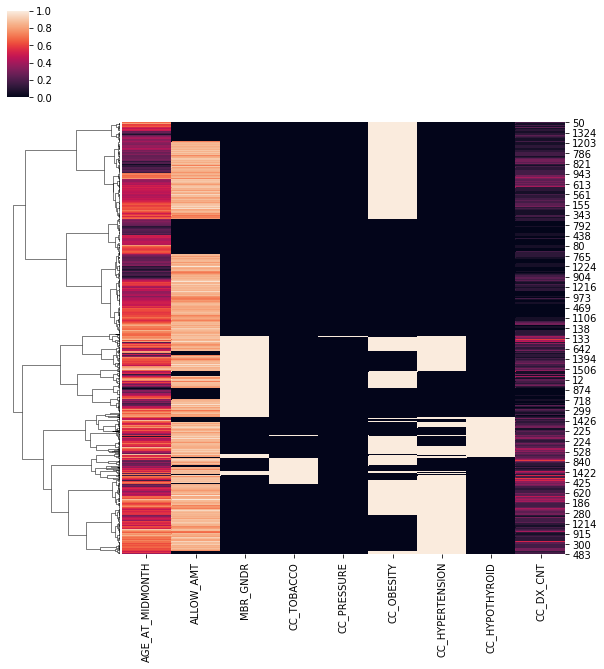

In [16]:
g = sns.clustermap(clustermapdat, method = 'ward', standard_scale=1, row_linkage = link_matr, col_cluster = False)

#### For each of the two clusters formed from the Treated patients form a matched population from the controls.
<div style="background:Aliceblue"> We use propensity score matching as our matching function</div>

In [42]:
pmpm.ER_BIN2.value_counts()

0    8035091
1     710791
2     116275
3      29267
4       9417
5       3633
6       1579
Name: ER_BIN2, dtype: int64

In [17]:
%%time

columns_to_match = columns_to_match + ['IP_BIN2', 'ER_BIN2', 'LOB']
propensity_func_args = {'match_on':columns_to_match, 'neighbors_per_treated': 5}
matched0, matched_data0 = matched_population(treated0.copy(), 
                                           controls.copy(),
                                           propensity_func, 
                                           propensity_func_args)

matched1, matched_data1 = matched_population(treated1.copy(), 
                                           controls.copy(),
                                           propensity_func, 
                                           propensity_func_args)

Mathcing Function: propensity_func
Propensity Score Matching...fitting model
Creating Matched Set...


787it [41:02,  3.13s/it]


Mathcing Function: propensity_func
Propensity Score Matching...fitting model
Creating Matched Set...


751it [39:34,  3.16s/it]


CPU times: user 1h 8min 14s, sys: 33min 49s, total: 1h 42min 3s
Wall time: 1h 26min 45s


####  In addition to the previously created matched groups create a random group

In [18]:
random_matching_func_args = {'neighbors_per_treated': 100}
random_controls = matched_population(treated2.copy(), 
                                       controls.copy(),
                                       random_matching_func, 
                                       random_matching_func_args)

Mathcing Function: random_matching_func


In [19]:
Path('./temp2').mkdir(exist_ok = True)
p = './temp2/'
matched_data0.to_pickle(p+'match0.p')
matched_data1.to_pickle(p+'match1.p')
random_controls.to_pickle(p+'random.p')
treated0.to_pickle(p+'treated0.p')
treated1.to_pickle(p+'treated1.p')

#### Calculate the Diabetes onset for each of the created groups
1. Group 0: Group of treated patients cluster 0
2. Group 1: Group of treated patients Cluster 1
3. Group 2: Group of matched control patients to Group 0
4. Group 3: Group of matched control patients to Group 1
5. Group 4: Random Group

In [20]:
%%time
con_onset0 = diabet_onset(matched_data0.copy(), 'Diabetes_Con0')
con_onset1 = diabet_onset(matched_data1.copy(), 'Diabetes_Con1')

treated_onset0 = diabet_onset(treated0.copy(), 'Diabetes_Tr')
treated_onset1 = diabet_onset(treated1.copy(), 'Diabetes_Tr')

pmpm2 = filter_first_month_diabetes(pmpm.copy())
pmpm_onset = diabet_onset(pmpm2, 'Diabetes_PM')

CPU times: user 4min 4s, sys: 10.9 s, total: 4min 15s
Wall time: 4min 13s


In [21]:
random_onset = diabet_onset(random_controls.copy(), 'Diabetes_Rnd')

In [22]:
con_onset20 = con_onset0.rename(columns = {'Sample': 'Sample_Con0', 'Per_1000':'Per_1000_Con0'})
con_onset21 = con_onset1.rename(columns = {'Sample': 'Sample_Con1', 'Per_1000':'Per_1000_Con1'})

treated_onset20 = treated_onset0.rename(columns = {'Sample': 'Sample_Tr0', 'Per_1000':'Per_1000_Tr0'})
treated_onset21 = treated_onset1.rename(columns = {'Sample': 'Sample_Tr1', 'Per_1000':'Per_1000_Tr1'})

pmpm_onset2 = pmpm_onset.rename(columns = {'Sample': 'Sample_PM', 'Per_1000':'Per_1000_PM'})

In [23]:
random_onset2 = random_onset.rename(columns = {'Sample': 'Sample_PM', 'Per_1000':'Per_1000_PM'})
joint = pd.concat((con_onset20, con_onset21, treated_onset20, treated_onset21,  pmpm_onset2, random_onset2), axis = 1)

### Diabetes Onset Per Month Statistics

1. **_Con{i} : For Matched Controls Population**
2.  **_Tr{i} : For Canary Treated Population**
3. **_PM : For the whole PMPM Population**
4. **_Rnd: For a Random Matching**

>Sample_: The number of patients per month  
Diabetes_: The number of patients with Diabetes Onset in a month  
Per_1000_: The number of patients with Diabetes Onset in a a month per 1000  


In [24]:
joint.describe().loc[['mean', 'std']]

Sample_Con0  Diabetes_Con0  Per_1000_Con0  Sample_Con1  Diabetes_Con1  Per_1000_Con1  Sample_Tr0  Diabetes_Tr  Per_1000_Tr0  Sample_Tr1  Diabetes_Tr  Per_1000_Tr1      Sample_PM  Diabetes_PM  Per_1000_PM     Sample_PM  Diabetes_Rnd  Per_1000_PM
mean   1241.50000       2.342105       2.098634  1035.142857       1.261905       1.167098  267.052632     0.657895      1.944634  237.880952     0.404762      1.080297  143003.882353   279.901961     1.961085  32656.619048     58.023810     1.760473
std    1046.70419       2.362732       1.975000   980.128403       1.326273       1.603212  227.457504     0.937977      4.332846  228.253838     0.700506      1.992007   13718.389511    44.775554     0.272818  28435.537611     50.328428     0.903969

In [25]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-dark')

In [26]:
joint2 = pd.concat((con_onset0, con_onset1, treated_onset0, treated_onset1,  pmpm_onset, random_onset), axis = 1)
jointcon0 = joint2.Per_1000.iloc[1:, 0].reset_index()
jointcon1 = joint2.Per_1000.iloc[1:, 1].reset_index()
jointTr0 = joint2.Per_1000.iloc[1:, 2].reset_index()

jointTr1 = joint2.Per_1000.iloc[1:, 3].reset_index()
jointpmpm = joint2.Per_1000.iloc[1:, 4].reset_index()
jointrandom = joint2.Per_1000.iloc[1:, 5].reset_index()


<div style="background:Aliceblue"> 
    <h3> Plot Top Left: $f(x)$ = Onset Per 1000 per month </h3>
    <h3> Plot Top Right and Bottom Left: $F(x) = \int_0^x f(y)dy$ <br>
        Cumulative sum of the rates </h3>
</div>

In [27]:
from diabetes_onset_plotter import plot_onset, plot_onset2
names = ['Sick Controls', 'Healthy Controls', 'Sick Treated', 'Healthy Treated']#, 'Random']
f, ax = plot_onset2(jointcon0, jointcon1, jointTr0, jointTr1, names = names)
#f.savefig('figs/onset.png')
plt.show()

No handles with labels found to put in legend.


In [28]:
a = treated0.groupby(['PERS_ID']).apply(lambda x: pd.Series([x.MBR_GNDR.sum(), len(x)], index = ['GEN', 'LEN'])).reset_index(drop = True)

In [29]:
def statistics_first_month(df, columns_to_match):
    df = df.sort_values(by = ['PERS_ID', 'MYR'])
    df = df.groupby('PERS_ID').apply(lambda x: pd.Series(x.iloc[0])).reset_index(drop = True)
    return df[columns_to_match].describe().loc[['mean']]#, df

In [30]:
try:
    pmpm2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
except:
    pass

In [31]:
%%time
tr_desc0 = statistics_first_month(treated0, columns_to_match)
tr_desc0 = tr_desc0.T

tr_desc1 = statistics_first_month(treated1, columns_to_match)
#tr_desc.index = pd.MultiIndex.from_product([['Treated'], tr_desc.index])
tr_desc1 = tr_desc1.T

con_desc0 = statistics_first_month(matched_data0, columns_to_match)
#con_desc.index = pd.MultiIndex.from_product([['Matched'], con_desc.index])
con_desc0 = con_desc0.T

con_desc1 = statistics_first_month(matched_data1, columns_to_match)
#con_desc.index = pd.MultiIndex.from_product([['Matched'], con_desc.index])
con_desc1 = con_desc1.T

pmpm_desc = statistics_first_month(pmpm2, columns_to_match)
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
pmpm_desc = pmpm_desc.T

random_desc = statistics_first_month(random_controls, columns_to_match)
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
random_desc = random_desc.T

CPU times: user 2min 41s, sys: 3.19 s, total: 2min 44s
Wall time: 2min 44s


In [32]:
alli = pd.concat((tr_desc0, tr_desc1, con_desc0, con_desc1, pmpm_desc, random_desc), axis = 1, keys = ['Sick Treated','Healthy Treated',
                                                                                                       'Sick Controls', 'Healthy Controls',
                                                                                                       'Genaral Population', 'Random'] )

## Statistics on matching date

In [33]:
alli

Sick Treated Healthy Treated Sick Controls Healthy Controls Genaral Population      Random
                        mean            mean          mean             mean               mean        mean
AGE_AT_MIDMONTH    53.608640       46.186418     53.352771        49.747661          43.048583   47.234847
ALLOW_AMT         815.396442      535.544607    827.200683       600.539626         986.578600  750.230425
MBR_GNDR            0.396442        0.000000      0.382716         0.000275           0.432864    0.425216
CC_TOBACCO          0.124524        0.000000      0.082217         0.059163           0.072285    0.095953
CC_PRESSURE         0.002541        0.000000      0.006042         0.004403           0.003787    0.005924
CC_OBESITY          0.454892        0.451398      0.432887         0.289213           0.092396    0.220597
CC_HYPERTENSION     0.627700        0.000000      0.618860         0.193726           0.174132    0.245384
CC_HYPOTHYROID      0.180432        0.000000      0.123982         0.057237           0.041370    0.063341
CC_DX_CNT           3.440915        1.766977      3.314946         2.181343           1.531662    2.298980
IP_BIN2             0.043202        0.006658      0.030733         0.025592           0.018782    0.045060
ER_BIN2             0.106734        0.057257      0.060678         0.074849           0.047123    0.123252
LOB                 0.947903        0.958722      0.885211         0.927903           0.752927    0.785727

In [34]:
tr_desc0 = treated0[columns_to_match].describe().loc[['mean']]
#tr_desc.index = pd.MultiIndex.from_product([['Treated'], tr_desc.index])
tr_desc0 = tr_desc0.T

tr_desc1 = treated1[columns_to_match].describe().loc[['mean']]
#tr_desc.index = pd.MultiIndex.from_product([['Treated'], tr_desc.index])
tr_desc1 = tr_desc1.T

con_desc0 = matched_data0[columns_to_match].describe().loc[['mean']]
#con_desc.index = pd.MultiIndex.from_product([['Matched'], con_desc.index])
con_desc0 = con_desc0.T

con_desc1 = matched_data1[columns_to_match].describe().loc[['mean']]
#con_desc.index = pd.MultiIndex.from_product([['Matched'], con_desc.index])
con_desc1 = con_desc1.T

pmpm_desc = pmpm2[columns_to_match].describe().loc[['mean']]
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
pmpm_desc = pmpm_desc.T

random_desc = random_controls[columns_to_match].describe().loc[['mean']]
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
random_desc = random_desc.T

alli = pd.concat((tr_desc0, tr_desc1, con_desc0, con_desc1, pmpm_desc, random_desc), axis = 1, keys = ['Sick Treated','Healthy Treated',
                                                                                                       'Sick Controls', 'Healthy Controls',
                                                                                                       'Genaral Population', 'Random'] )

#### Univariate Means of the Groups under Study of interesting features (Statistics for whole populations)
>The "Sick groups" have:  
a) Older age  
b) More Expenditures  
c) Smoke More  
d) Have More People with Hypertension


In [35]:
alli

Sick Treated Healthy Treated Sick Controls Healthy Controls Genaral Population      Random
                        mean            mean          mean             mean               mean        mean
AGE_AT_MIDMONTH    54.036866       46.804141     54.753939        51.191308          48.759167   49.945624
ALLOW_AMT         899.432035      620.566596    907.075146       671.144329         748.531555  740.195295
MBR_GNDR            0.368564        0.000000      0.361677         0.000503           0.421103    0.419869
CC_TOBACCO          0.115681        0.014974      0.089121         0.073934           0.099304    0.103662
CC_PRESSURE         0.004358        0.000000      0.007734         0.004189           0.007168    0.007314
CC_OBESITY          0.472169        0.516868      0.461012         0.319447           0.231656    0.276670
CC_HYPERTENSION     0.565241        0.069507      0.582230         0.239481           0.283097    0.293644
CC_HYPOTHYROID      0.160174        0.026990      0.121431         0.075799           0.069572    0.074754
CC_DX_CNT           3.454372        2.153434      3.549881         2.558697           2.539357    2.723638
IP_BIN2             0.034777        0.013125      0.049871         0.035941           0.047520    0.046379
ER_BIN2             0.097340        0.055828      0.082647         0.083590           0.118977    0.112900
LOB                 0.951875        0.960255      0.891710         0.926945           0.797746    0.803632

#### Distribution Plots For Treated and Matched Controls
1)  Sick(S) Treated versus  Sick Control groups  
2) Healthy(H) Treated versus Healthy Control Groups

In [36]:
def plot0():
    fig, ax = plt.subplots(3,3, figsize = (15,9))
    for i in range(3):
        for j in range(3):
            column = columns_to_match[i*3 + j]
            if column == 'ALLOW_AMT':
                treated00 = treated0.copy()
                treated00[column] = np.log(treated00[column].values + 10**(-10))
                matched00 = matched_data0.copy()
                matched00[column] = np.log(matched00[column].values + 10**(-10))

                sns.distplot(treated00[column], ax = ax[i,j])
                sns.distplot(matched00[column], ax = ax[i,j])
                ax[i,j].legend(['S Treated', 'S Controls'])
            else:
                sns.distplot(treated0[column], ax = ax[i,j])
                sns.distplot(matched_data0[column], ax = ax[i, j])
                ax[i,j].legend(['S Treated', 'S Controls'])
                
    return fig, ax

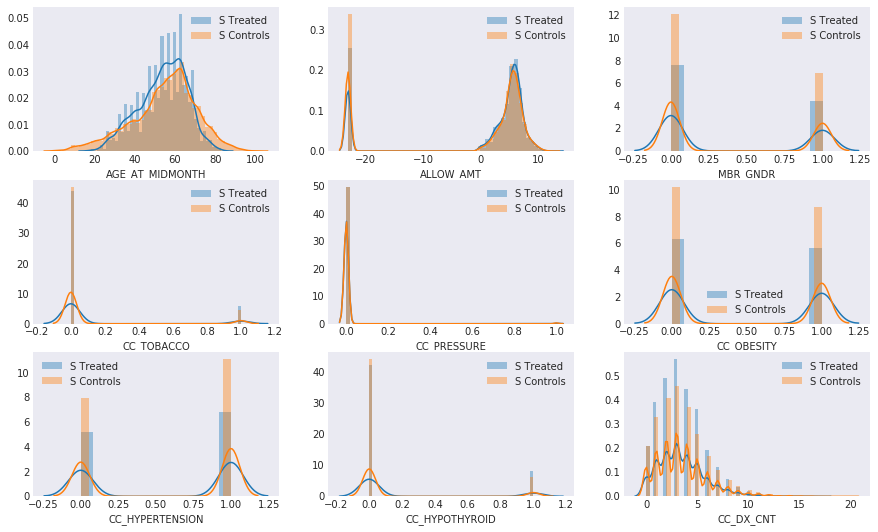

In [37]:
f0, ax0 = plot0()

In [38]:
def plot1():
    fig, ax = plt.subplots(3,3, figsize = (15,9))
    for i in range(3):
        for j in range(3):
            column = columns_to_match[i*3 + j]

            try:
                if column == 'ALLOW_AMT':
                    treated00 = treated1.copy()
                    treated00[column] = np.log(treated00[column].values + 10**(-10))
                    matched00 = matched_data1.copy()
                    matched00[column] = np.log(matched00[column].values + 10**(-10))

                    sns.distplot(treated00[column], ax = ax[i,j])
                    sns.distplot(matched00[column], ax = ax[i,j])
                    ax[i,j].legend(['H Treated', 'H Controls'])
                else:
                    sns.distplot(treated1[column], ax = ax[i,j])
                    sns.distplot(matched_data1[column], ax = ax[i, j])
                    ax[i,j].legend(['H Treated', 'H Controls'])
                    ax.set_title('Bla')
            except:
                continue
    return fig, ax

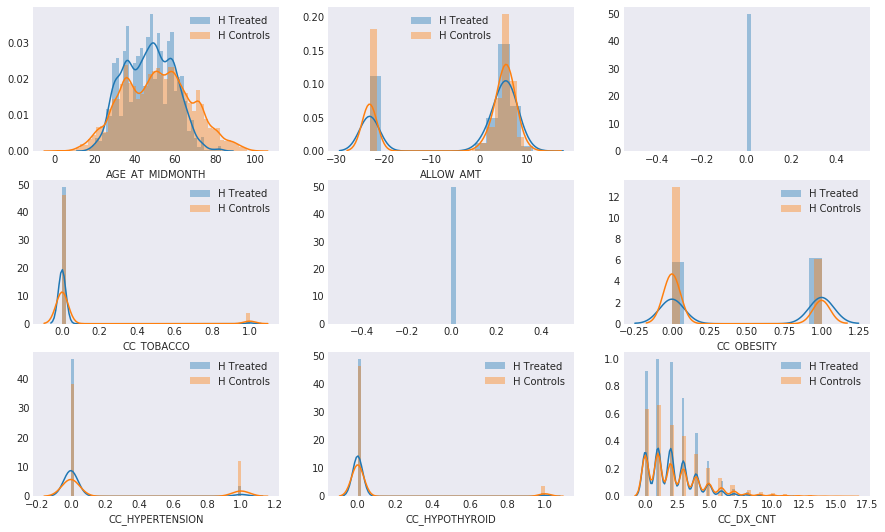

In [39]:
f1, ax1 = plot1()